In [1]:
import os
import shutil

base_dir = 'train_petimages'

cat_dir = os.path.join(base_dir, 'cats')
dog_dir = os.path.join(base_dir, 'dogs')

os.makedirs(cat_dir, exist_ok=True)
os.makedirs(dog_dir, exist_ok=True)

for filename in os.listdir(base_dir):
    if filename.startswith('cat'):
        shutil.move(os.path.join(base_dir, filename), cat_dir)
    elif filename.startswith('dog'):
        shutil.move(os.path.join(base_dir, filename), dog_dir)

In [2]:
import os
from PIL import Image
import shutil

def is_valid_image(file_path):
    try:
        img = Image.open(file_path)
        img.verify()
        return True
    except:
        return False

def clean_image_dir(base_dir):
    corrupted_files = []

    for root,dirs, files in os.walk(base_dir):
        for filename in files:
            file_path = os.path.join(root, filename)
            if not is_valid_image(file_path):

                corrupted_files.append(file_path)

                os.remove(file_path)

                print(f"removed corrupted file : {file_path}")
    return corrupted_files

corrupted_files = clean_image_dir('train_petimages')

In [17]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.layers import BatchNormalization
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt

# Set paths
train_dir = 'train_petimages'
test_dir = 'test_petimagesV2'

# Parameters
IMG_SIZE = (150, 150)
BATCH_SIZE = 32


In [18]:
# Data Augmentation with additional transformations
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    brightness_range=[0.8, 1.2],  # Added brightness adjustment
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation'
)


Found 15999 images belonging to 2 classes.
Found 3998 images belonging to 2 classes.


In [19]:
# Define CNN Model with Batch Normalization
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    BatchNormalization(),  # Added BatchNormalization
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),  # Added BatchNormalization
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),  # Added BatchNormalization
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),  # Added BatchNormalization
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(512, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)


In [20]:
# Train the model with increased epochs
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,  # Increased epochs for better learning
    verbose=1
)

# Save the model
model.save('cat_dog_classifier.h5')


Epoch 1/10
500/500 [==============================] - 925s 2s/step - loss: 0.7361 - accuracy: 0.6310 - val_loss: 0.6623 - val_accuracy: 0.5978
Epoch 2/10
500/500 [==============================] - 692s 1s/step - loss: 0.5672 - accuracy: 0.7047 - val_loss: 1.0686 - val_accuracy: 0.5048
Epoch 3/10
500/500 [==============================] - 735s 1s/step - loss: 0.5318 - accuracy: 0.7362 - val_loss: 0.5555 - val_accuracy: 0.7241
Epoch 4/10
500/500 [==============================] - 877s 2s/step - loss: 0.4856 - accuracy: 0.7643 - val_loss: 0.5802 - val_accuracy: 0.6848
Epoch 5/10
500/500 [==============================] - 826s 2s/step - loss: 0.4332 - accuracy: 0.7964 - val_loss: 0.5536 - val_accuracy: 0.7511
Epoch 6/10
500/500 [==============================] - 871s 2s/step - loss: 0.4039 - accuracy: 0.8161 - val_loss: 0.5024 - val_accuracy: 0.7504
Epoch 7/10
500/500 [==============================] - 742s 1s/step - loss: 0.3715 - accuracy: 0.8321 - val_loss: 0.4084 - val_accuracy: 0.8154

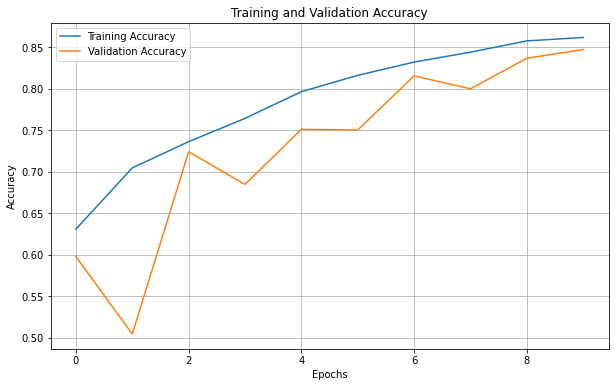

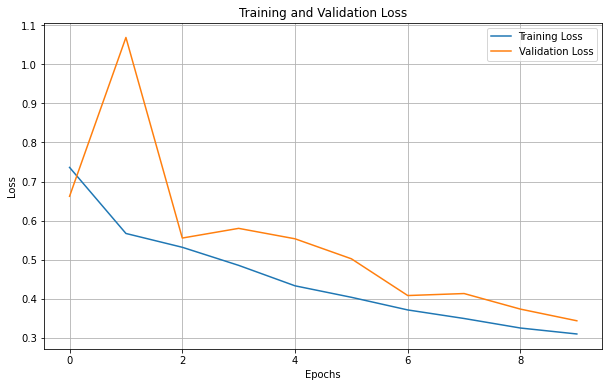

In [21]:
# Plot training and validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [22]:
# Prepare Test Data
test_datagen = ImageDataGenerator(rescale=1.0 / 255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=1,
    class_mode=None,
    shuffle=False
)

# Predictions
predictions = model.predict(test_generator)
predicted_labels = ['dog' if pred > 0.5 else 'cat' for pred in predictions]

# For submission, ensure filenames are correctly formatted
image_ids = [os.path.splitext(os.path.basename(f))[0] for f in test_generator.filenames]

# Create Submission File
submission = pd.DataFrame({'ImageId': image_ids, 'Label': predicted_labels})
submission.to_csv('submission1.csv', index=False)
print("Submission saved as submission1.csv")


Found 5000 images belonging to 1 classes.
4904/5000 [============================>.] - ETA: 2s

/opt/anaconda3/lib/python3.9/site-packages/PIL/TiffImagePlugin.py:819: UserWarning: Truncated File Read
  warnings.warn(str(msg))


5000/5000 [==============================] - 119s 24ms/step
Submission saved as submission1.csv


1/1 [==============================] - 0s 381ms/step


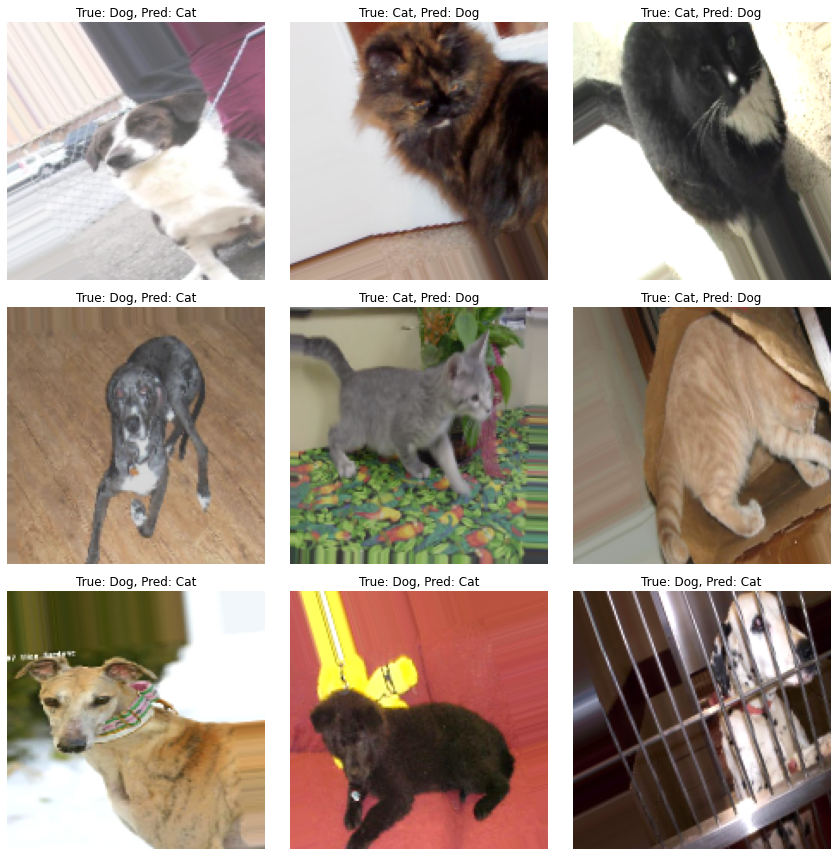

In [23]:
def visualize_misclassifications(model, generator, num_images=9):
    """
    Visualizes misclassified images from a generator.

    Args:
        model: Trained Keras model.
        generator: Data generator (e.g., validation_generator).
        num_images: Number of misclassified images to display.
    """
    # Reset generator to start from the beginning
    generator.reset()

    misclassified_images = []
    misclassified_labels = []
    misclassified_preds = []

    for images, labels in generator:
        preds = model.predict(images)
        preds = (preds > 0.5).astype(int).flatten()
        labels = labels.astype(int).flatten()

        for i in range(len(labels)):
            if preds[i] != labels[i]:
                misclassified_images.append(images[i])
                misclassified_labels.append(labels[i])
                misclassified_preds.append(preds[i])

            if len(misclassified_images) >= num_images:
                break
        if len(misclassified_images) >= num_images:
            break

    # Plot the misclassified images
    plt.figure(figsize=(12, 12))
    for i in range(len(misclassified_images)):
        plt.subplot(int(np.sqrt(num_images)), int(np.sqrt(num_images)), i + 1)
        plt.imshow(misclassified_images[i])
        plt.title(
            f"True: {'Dog' if misclassified_labels[i] == 1 else 'Cat'}, "
            f"Pred: {'Dog' if misclassified_preds[i] == 1 else 'Cat'}"
        )
        plt.axis('off')
    plt.tight_layout()
    plt.show()

visualize_misclassifications(model, val_generator, num_images=9)
